# Setup

In [1]:
# Auto reload settings
#%%

%load_ext autoreload
%autoreload 2
!jupyter nbextension enable --py widgetsnbextension


import warnings
warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
# Imports

%load_ext autoreload
import sys

from entropy_aware_search.hf_utils import DataArguments, ModelArguments, get_tokenizer, get_model
from entropy_aware_search.utils import compute_average_across_sequences, process_datapoint

from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForLanguageModeling
from parlai.utils.strings import colorize
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import copy
pd.options.plotting.backend = "matplotlib"



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# Load Pegasus fine-tuned on cnn_dailymail

model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")

model = model.to('cuda')
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")

In [9]:
from typing import List, Union
from parlai.utils.strings import colorize
import copy
def compute_ngram_repeats(context: Union[str, List], model_text: Union[str, List], n=3, splitted=False):
    cgrams = {}
    # compute N grams of the context
    
    if not splitted:
        context = context.split(' ')
        model_text = model_text.split(' ')

    for i in range(n, len(context) + 1):
        ngram = ' '.join(context[i - n : i])
        cgrams[ngram] = True
    # compute N grams of the model response
    creps = 0
    lreps = 0
    repetition_idxs = [0] * len(model_text)
    lreps_idxs = [0] * len(model_text)
    creps_idxs = [0] * len(model_text)
    
    lgrams = {}

    for i in range(n, len(model_text) + 1):
        ngram = ' '.join(model_text[i - n : i])
        
        if ngram in cgrams:
            creps = creps + 1
            repetition_idxs[i-1] = 1
            creps_idxs[i-1] = 1
        
        if ngram in lgrams:
            lreps = lreps + 1
            repetition_idxs[i-1] = 1
            lreps_idxs[i-1] = 1
           
        lgrams[ngram] = True
    
    for i in range(n-1, len(model_text)):
        if repetition_idxs[i] == 1:
            for j in range(1, n):
                repetition_idxs[i-j] = 1

        if creps_idxs[i] == 1:
            for j in range(1, n):
                creps_idxs[i-j] = 1

        if lreps_idxs[i] == 1:
            for j in range(1, n):
                lreps_idxs[i-j] = 1

    return creps + lreps, creps, lreps, repetition_idxs, creps_idxs, lreps_idxs


def print_with_colors(text, repeat_indices, color='red'):
    colorized_tokens = []
    tokenized_text = text.split(" ")
    
    is_repeat_indices = copy.copy(repeat_indices)
    for (token, is_repeat) in zip(tokenized_text, is_repeat_indices):
       
        if is_repeat:
            colorized_token = colorize(token, color)
        else:
            colorized_token = token

        colorized_tokens.append(colorized_token)

    return " ".join(colorized_tokens)

def print_sample(context, model_text, repeat_type='all', color='red'):
    _, _, _, arep_idxs, crep_idxs, lrep_idxs = compute_ngram_repeats(context, model_text)
    # print(context)

    rep_idxs = None
    if repeat_type == 'all':
        rep_idxs = arep_idxs
    elif repeat_type == 'context':
        rep_idxs = crep_idxs
    elif repeat_type == 'labels':
        rep_idxs = lrep_idxs

    print(print_with_colors(model_text, rep_idxs, color=color))

In [8]:
# Plot mean and std average entropy

def plot_avg_entropies_mean_std(entropies, label=None, ax=None,  color='red', linewidth=1, std_dev=1):
    entropy_mean = np.ma.mean(entropies, axis=0)
    entropy_std = np.ma.std(entropies, axis=0)
    ax = sns.lineplot(y=entropy_mean, x=np.arange(len(entropy_mean)), 
                    ax=ax, label=label, color=color, linewidth=linewidth)
    # sns.lineplot(entropy_mean, ax=ax, label=label)

    ax.set_ylim(0,6)
    ax.fill_between(range(len(entropy_mean)), entropy_mean -  std_dev * entropy_std, 
                                                entropy_mean +  std_dev * entropy_std, alpha=0.1, color=color)
    # ax=ax.set_xticks(np.arange(len(entropy_mean)), step=100)


# Constants

In [11]:
# Data
orig_wp = '/home/mila/a/arorakus/wdir/entropy_aware_search/data/cnn_dm_pegasus/generated/orig.jsonl'
beam_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/cnn_dm_bart/generated/beam_5.json"
# eabs_generation = '/home/mila/a/arorakus/wdir/entropy_aware_search/data/cnn_dm_pegasus/generated/eabs_beams_5_width_5_alpha_5.csv'
# all_generation = '/home/mila/a/arorakus/wdir/entropy_aware_search/data/cnn_dm_pegasus/generated/all.csv'

In [6]:
NUM_SEQ=1000
MAX_LEN = 128
MAX_SOURCE_LEN=1024
WIDTH=5

# Entropy of Human Data

In [12]:
human_dataframe = pd.read_json(orig_wp, lines=True)\
                        .rename(columns={'prefix':'context', 
                                         'target': 'model_text'})

In [30]:
human_datapoint = human_dataframe.sample(1).iloc[0]
print(human_datapoint.context)
print()
print_sample(human_datapoint.context, human_datapoint.model_text)

(CNN)The Tulsa County reserve deputy who fatally shot a man instead of using his Taser turned himself in to authorities Tuesday at the Tulsa County Jail. Video shows Reserve Deputy Robert Bates announcing he is going to deploy his Taser after an undercover weapons sting on April 2 but then shooting Eric Courtney Harris in the back with a handgun. Bates was charged with second-degree manslaughter Monday. He surrendered Tuesday morning, accompanied by his attorney, Clark Brewster, and immediately posted bail of $25,000. As he exited the jailhouse, Bates paused in front of television cameras for a moment but did not speak. His attorney reiterated that he believes the charge against his client is unwarranted. The Tulsa County Sheriff's Office says a sting operation caught Harris illegally selling a gun. Harris ran when officers came in for the arrest. Authorities say Bates thought he pulled out his Taser but "inadvertently" fired his gun. Harris' brother, Andre Harris, told CNN that he is 

## Compute Average entropy across sequences.

In [14]:
human_avg_entropy_pd, human_entropies = compute_average_across_sequences(human_dataframe, model, tokenizer, column_prefix='human_generated',  max_len=MAX_LEN, num_seq=NUM_SEQ, is_seq2seq=True, max_source_len=MAX_SOURCE_LEN, cache=True)
human_avg_ma_entropy_pd, human_ma_entropies = compute_average_across_sequences(human_dataframe, model, tokenizer, column_prefix='human_generated', width=WIDTH,  max_len=MAX_LEN, to_be_averaged='entropy_ma', num_seq=NUM_SEQ, cache=True, is_seq2seq=True, max_source_len=MAX_SOURCE_LEN)

Saving to:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/65435bd7eabc56bf4143ddbd46654176-5b42467931ab343e502e9a74e5e22ed3-human_generated-128-1000-entropy-1-1024-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/65435bd7eabc56bf4143ddbd46654176-5b42467931ab343e502e9a74e5e22ed3-human_generated-128-1000-entropy-1-1024-avgs.csv
Loading from:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/65435bd7eabc56bf4143ddbd46654176-5b42467931ab343e502e9a74e5e22ed3-human_generated-128-1000-entropy_ma-5-1024-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/65435bd7eabc56bf4143ddbd46654176-5b42467931ab343e502e9a74e5e22ed3-human_generated-128-1000-entropy_ma-5-1024-avgs.csv


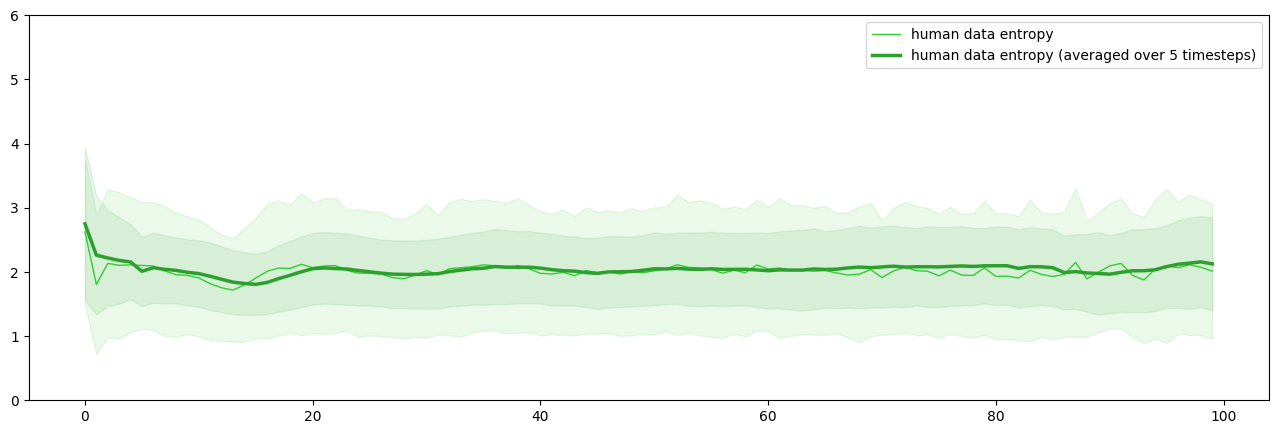

In [46]:
fig, ax = plt.subplots(figsize=(16, 5))
plot_avg_entropies_mean_std(human_entropies, 'human data entropy', color='limegreen')
plot_avg_entropies_mean_std(human_ma_entropies, 'human data entropy (averaged over 5 timesteps)', color='tab:green', linewidth=2.5)

## Examples of generation

In [16]:

lpdh = process_datapoint(
    model=model, tokenizer=tokenizer, datapoint=human_datapoint, width=WIDTH, max_len=MAX_LEN,  is_seq2seq=True, max_source_len=MAX_SOURCE_LEN, 
)

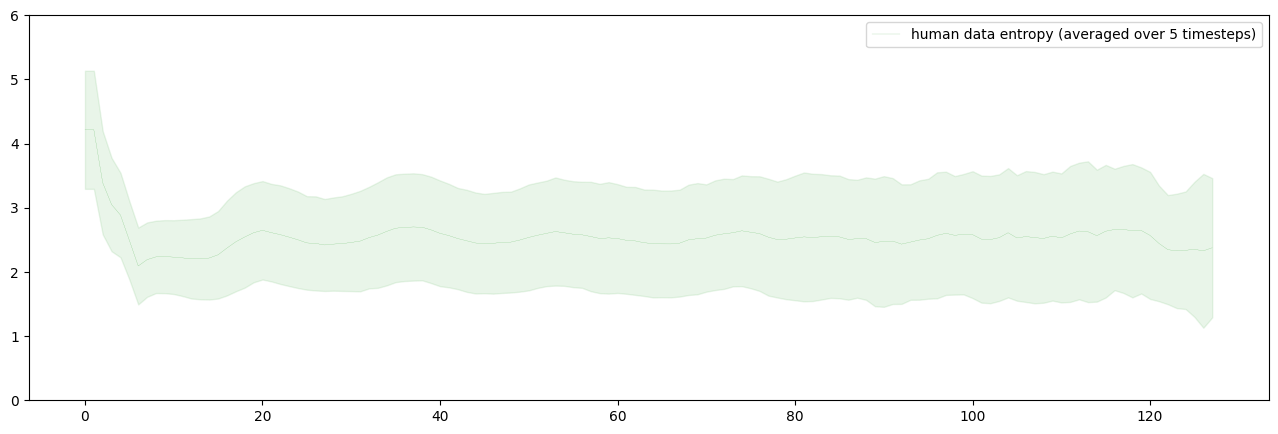

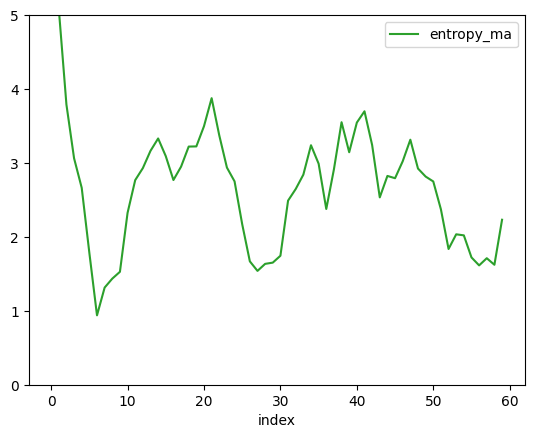

In [24]:
fig, ax = plt.subplots(figsize=(16, 5))
# lpdh.plot.bar(x='index', y='is_lrep', ax=ax2, fill=True, rot='60')

# lpdh.plot(x="index", y='entropy', ylim=(0,8), ax=ax, color='darkgreen')
lpdh.plot(x="index", y='entropy_ma', ylim=(0,5), color='tab:green')
# ax.set_xticks(np.arange(len(lpdh['index']), step=30))

plot_avg_entropies_mean_std(human_ma_entropies, 'human data entropy (averaged over 5 timesteps)', ax=ax, color='tab:green', linewidth=0.1)

# Entropy of Model Data

In [25]:
model_beam_dataframe = pd.read_json(beam_generation, lines=True)\
                                .rename(columns={'prefix':'context', 
                                                 'generation': 'model_text'})

## EABS Comparison Example

In [40]:
human_datapoint_idx = 103

In [41]:
human_datapoint = human_dataframe.iloc[human_datapoint_idx]

beam_sample = model_beam_dataframe.iloc[human_datapoint_idx]

In [42]:
print("Document:")
print(human_datapoint.context)
print()
print("Target:")
print(human_datapoint.model_text)
print()
print("Beam Summary: ")
print_sample(human_datapoint.context, beam_sample.model_text)
print()

Document:
(CNN)Do you remember the talk about plans for Iraqi-led force to try to take back Mosul this spring? Well, you might want to forget it. Nearly three months after a U.S. official said up to 25,000 Iraqis troops were expected to return to the key northern Iraqi city in April or May, a senior official in President Barack Obama's administration said Thursday that Washington is "not putting a timeframe on" a possible invasion. It "might be some time from now. Might be soon," another senior administration official said. Mosul has long been the big prize in the Iraqi government's fight -- aided by a U.S.-led military coalition, which has carried out airstrikes for months -- to defeat ISIS. It has also long been a source of embarrassment, considering how it fell after Iraqi troops dropped their weapons, abandoned their posts and ran for their lives when militants arrived last June. The senior administration officials who talked to reporters Thursday stressed the Iraqis and their alli

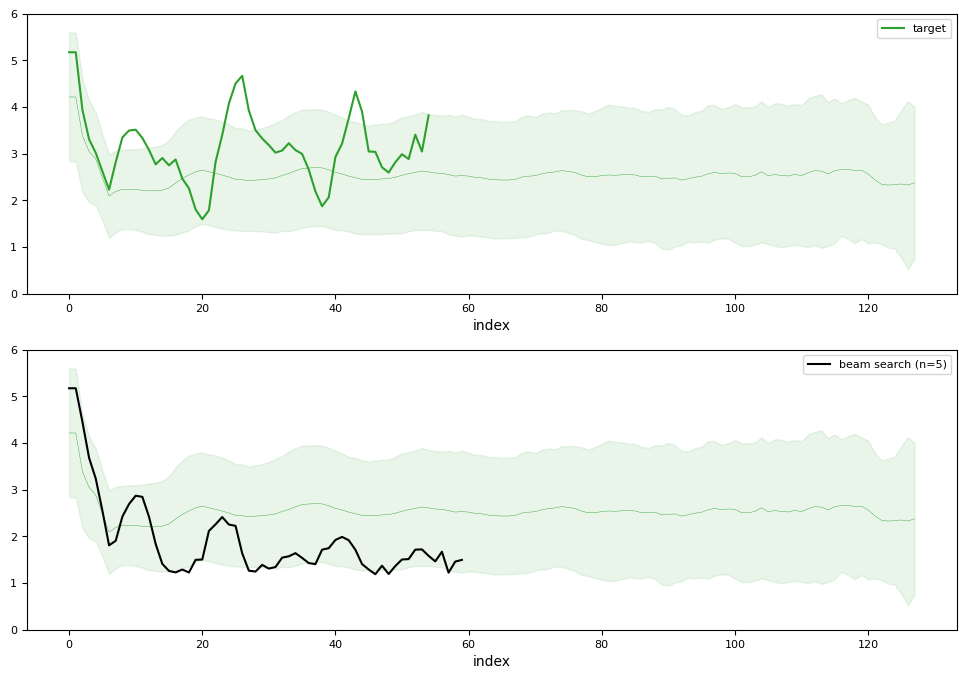

: 

In [44]:
lpdh = process_datapoint(
    model=model, tokenizer=tokenizer, datapoint=human_datapoint, width=WIDTH, max_len=MAX_LEN,  is_seq2seq=True, max_source_len=MAX_SOURCE_LEN, 
)

beam_labeled_datapoint = process_datapoint(
    model=model, tokenizer=tokenizer, datapoint=beam_sample, width=WIDTH, max_len=MAX_LEN,  is_seq2seq=True, max_source_len=MAX_SOURCE_LEN, 
)

fig, axs = plt.subplots(2, figsize=(12, 8))
plot_avg_entropies_mean_std(human_ma_entropies,  ax=axs[0], color='tab:green', std_dev=1.5, linewidth=0.3)
lpdh.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[0], label='target', color='tab:green')
axs[0].legend(fontsize=8, loc="upper right")
axs[0].tick_params(labelsize=8)


plot_avg_entropies_mean_std(human_ma_entropies,  ax=axs[1], color='tab:green', std_dev=1.5, linewidth=0.3)
beam_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[1], label='beam search (n=5)', color='black')
axs[1].legend(fontsize=8, loc="upper right")
axs[1].tick_params(labelsize=8)

## Examples of various amounts of 3-gram repetition.

In [15]:
human_datapoint = human_dataframe.iloc[100]
# print()
# print(print_sample(human_datapoint.context, human_datapoint.model_text))

human_datapoint_idx = human_dataframe[(human_dataframe.model_text == human_datapoint.model_text)].index.item()

In [16]:
print("Context:")
print_sample(human_datapoint.model_text, human_datapoint.context, repeat_type="context")


Context:
(CNN)Anthony Ray Hinton is thankful to be free after nearly 30 years on Alabama's death row for murders he says he didn't commit. And incredulous that it took so long. Hinton, 58, looked up, took in the sunshine and thanked God and his lawyers Friday morning outside the county jail in Birmingham, minutes after taking his first steps as a free man since 1985. He spoke of unjustly losing three decades of his life, under fear of execution, for something he didn't do. "All they had to do was to test the gun, but when you think you're high and mighty and you're above the law, you don't have to answer to nobody," Hinton told reporters. "But I've got news for you -- everybody that played a part in sending me to death row, you will answer to God." Jefferson County Circuit Court Judge Laura Petro had ordered Hinton released after granting the state's motion to dismiss charges against him. Hinton was convicted of murder in the 1985 deaths of two Birmingham-area, fast-food restaurant man

In [21]:
human_datapoint = human_dataframe.sample(1).iloc[0]
human_datapoint_idx = human_dataframe[(human_dataframe.model_text == human_datapoint.model_text)].index.item()

beam_sample = model_beam_dataframe.iloc[human_datapoint_idx]
eabs_sample = model_eabs_dataframe.iloc[human_datapoint_idx]

print("Context:")
print_sample(beam_sample.model_text, human_datapoint.context, repeat_type='context', color='red')



print("Target:")
print_sample(human_datapoint.context, human_datapoint.model_text)
print()
print("Beam Summary: ")
print_sample(human_datapoint.context, beam_sample.model_text)
print()
print("EABS Summary: ")
print_sample(human_datapoint.context, eabs_sample.model_text)
print()

Context:
Security officers were out in force at Los Angeles International Airport on Saturday, allegedly after officials found out ISIS called for attacks on uniformed personnel as part of a possible terror plot. The FBI is investigating and security is being increased at other airports in Southern California because of a 'known threat' to LAX from ISIS, according to a federal law enforcement official. The investigation and security increase started after intercepted communication and other intelligence information led officials to believe that a plot could be under way. Scroll down for video. Security is being increased at airports in Southern California because of a 'known threat' from ISIS at LAX. Officials found out earlier that ISIS called for attacks on uniformed personnel as part of a possible terror plot. The federal law enforcement official did not say whether this was a new threat. The Transportation Security Administration alerted local law enforcement agencies responsible f

<AxesSubplot:xlabel='index'>

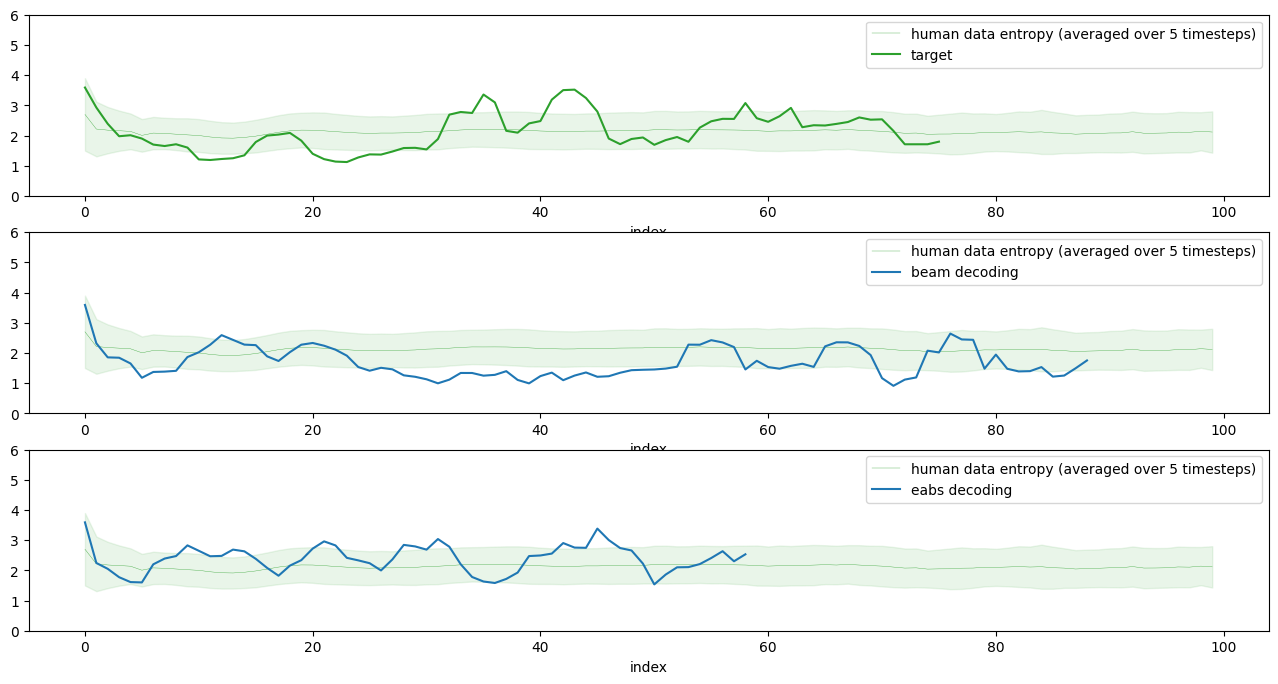

In [18]:

lpdh = process_datapoint(
    model=model, tokenizer=tokenizer, datapoint=human_datapoint, width=WIDTH, max_len=MAX_LEN,  is_seq2seq=True, max_source_len=MAX_SOURCE_LEN, 
)

beam_labeled_datapoint = process_datapoint(
    model=model, datapoint=beam_sample, width=WIDTH, max_len=MAX_LEN, tokenizer=tokenizer, is_seq2seq=True, max_source_len=MAX_SOURCE_LEN, 
)

eabs_labeled_datapoint = process_datapoint(
    model=model, datapoint=eabs_sample, width=WIDTH, max_len=MAX_LEN, tokenizer=tokenizer, is_seq2seq=True, max_source_len=MAX_SOURCE_LEN, 
)

fig, axs = plt.subplots(3,1, figsize=(16, 8))
plot_avg_entropies_mean_std(human_ma_entropies, axs[0], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1, linewidth=0.25)
lpdh.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[0], label='target', color='tab:green')

plot_avg_entropies_mean_std(human_ma_entropies, axs[1], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1, linewidth=0.25)
beam_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[1], label='beam decoding', color='tab:blue')


plot_avg_entropies_mean_std(human_ma_entropies, axs[2], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1, linewidth=0.25)
eabs_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[2], label='eabs decoding', color='tab:blue')


# lpdm.plot(x="index", y='dent', ylim=(-4,6), ax=ax)
# ax.set_xticks(np.arange(len(lpdh['index']), step=20))

# ax.set_xlabel("Timestep")
# ax.set_ylabel("Entropy (Averaged over 5 timesteps)")

## Compute Average entropy across timesteps.

### For all model generated data

In [30]:
# Greedy

model_greedy_dataframe = model_beam_dataframe.dropna()
model_gen_greedy_avg_entropy_pd, model_gen_greedy_entropies = compute_average_across_sequences(model_greedy_dataframe, model, tokenizer, column_prefix='model_generated_greedy',  max_len=MAX_LEN, num_seq=NUM_SEQ, is_seq2seq=True, max_source_len=MAX_SOURCE_LEN, cache=True)

model_gen_greedy_avg_ma_entropy_pd, model_gen_greedy_ma_entropies = compute_average_across_sequences(model_greedy_dataframe, model, tokenizer, column_prefix='model_generated_greedy', width=WIDTH,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, is_seq2seq=True, max_source_len=MAX_SOURCE_LEN, cache=True)

<AxesSubplot:title={'center':'Average Entropy vs Timesteps (Model Data w/ Repetition)'}, xlabel='Timesteps', ylabel='Average Entropy'>

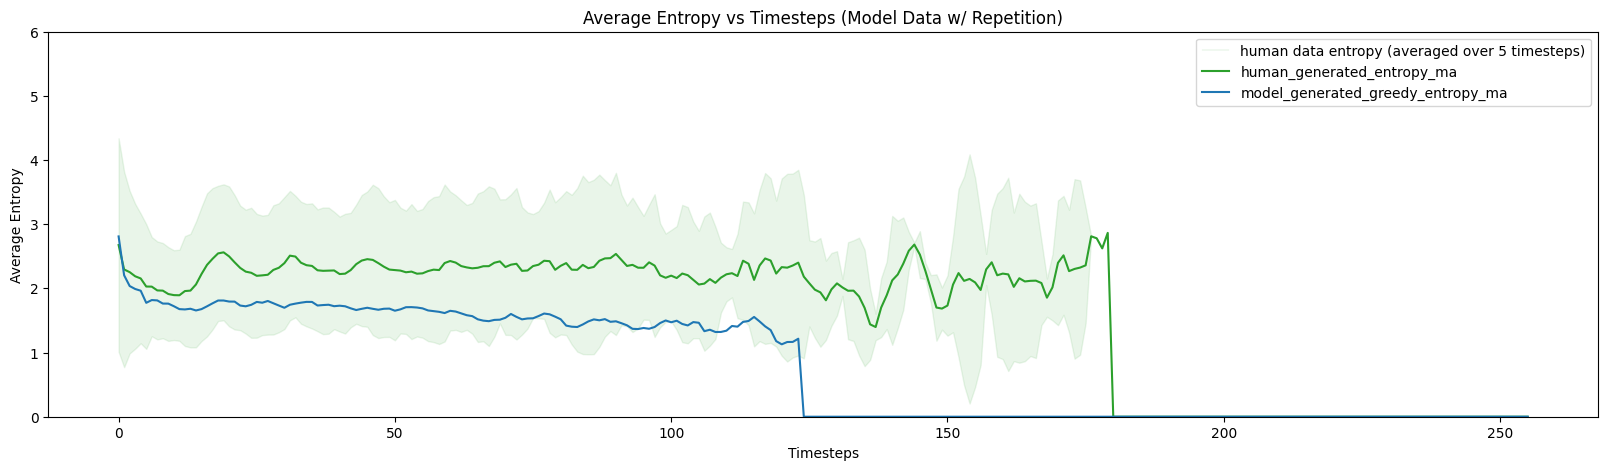

In [31]:
model_vs_human_avg_entropies = pd.concat([human_avg_ma_entropy_pd, model_gen_greedy_avg_ma_entropy_pd],axis=1)

fig, ax = plt.subplots(figsize=(16, 8))

plot_avg_entropies_mean_std(human_ma_entropies, ax, 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)

styles=['tab:green', 'tab:blue']
model_vs_human_avg_entropies.plot( 
    title='Average Entropy vs Timesteps (Model Data w/ Repetition)', 
    figsize=(20, 5),
    xlabel="Timesteps", 
    ylabel="Average Entropy",
    style=styles,
    ax=ax
)


# Do errors cascade?

In [ ]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = human_dataframe[human_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = model_greedy_dataframe[model_greedy_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = model_entropy_topk_dataframe[model_entropy_topk_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = model_entropy_aware_greedy_dataframe[model_entropy_aware_greedy_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

model_greedy_dataframe.num_3_gram_repeat.plot.hist(
        xlim=(0, 120), 
        xticks=range(0, 120, 5),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        )

model_greedy_dataframe.num_3_gram_repeat.plot.hist(
        xlim=(0, 120), 
        # xticks=range(0, 128),
        yticks=np.arange(0, 11, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # label="CDF"
)

ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences (w/o length normalization.")